# Preliminary Experiments for Compressible Hydrodynamics

Before jumping to the more advanced simulation of **Compressible Magnetohydrodynamics (CMHD)** I begin with studying the capacity of Dedalus3 to solve the compressible hydrodynamics, since the term that generate shocks $$\frac{\partial \ln \rho}{\partial t} = -\nabla \cdot \mathbf{u} - \mathbf{u} \cdot \nabla (\ln \rho) $$
might be unsolvable for Dedalus. This is due to shocks needing for high resolution, which can lead to an spectrum that does not converge.

Following the discussions in the Dedalus forum, I chose to solve for $\ln \rho$.

The equations to be solved are
\begin{align*}
\frac{\partial \ln \rho}{\partial t} &= -\nabla \cdot \mathbf{u} - \mathbf{u} \cdot \nabla (\ln \rho) \\
\frac{\partial \mathbf{u}}{\partial t} &= -\mathbf{u} \cdot \nabla \mathbf{u} - \frac{\nabla p}{\rho} - \nabla \Phi + \frac{\mathbf{j \times B}}{\rho} + \frac{\nabla \cdot (2\rho \nu \mathbf{S})}{\rho}\\
\frac{\partial s}{\partial t} &= - \mathbf{u} \cdot \nabla s + \frac{\eta \mu_0 |\mathbf{j} |^2}{\rho T} + \frac{2 \nu S^2}{T} 
\end{align*}

As for boundary conditions, I'm not sure as to which ones are appropiate for the problem to have physical relevance, but Nicolas suggested **no stress boundary conditions on the shell**. Since the outter region is a vacuum, I set a very low density in the shell $$\rho(r=R) = 10^{-4} \qquad \qquad \ln \rho (r=R) = -9.21034$$ 
And for simplicity I impose the boundary condition $$s(r=R) = 0$$

**Questions:**
In most of the literature and even Wikipedia, I see that the rate of shear tensor doesn't have the term $$-\frac{2}{3} \delta_{ij} \nabla \cdot \mathbf{u}$$

In [1]:
####------------------------Code parameters and Definitions----------------------#
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
from scipy.special import erf
#shutil.rmtree('snapshots', ignore_errors=True)
from mpl_toolkits.mplot3d import Axes3D
import logging
logger = logging.getLogger(__name__)
from scipy.interpolate import griddata
import matplotlib.colors as clr



#---------------------------Parameters------------------------------------#
Nphi, Ntheta, Nr = 128, 64, 96
dealias = 1                                             #Por ahora fijo en 1 porque da problemas si no.
dtype = np.float64
mesh = None
R = 1
gasconstant = 287
mapa2 = list(zip([0,.4,.5,.6,1.0], ["brown","yellow","gainsboro","aqua", "mediumblue"]))
cmapchi = clr.LinearSegmentedColormap.from_list("", mapa2, N=256) 
eta = 1000
sc,Tc,rho_c = 780, 500, 11
boundary_s , boundary_rho = 650,2
Gamma = 5/3
hyper_visc = 1e-12
cv = 717
mu = 28.97e-3
mu_0 = 1
nu = 1.6e-5


#--------------------------Funcion auxiliar para graficar-------------------#
def plot_mapa_calor(R, Theta, colormesh, ax,label,fig,plotcolorbar=True,cmap='PRGn',diverging=False,polar=True,vmin=0,vmax=100,autov=True):
    if diverging:
        lista_max = [max(colormesh[i]) for i in range(len(colormesh))]
        vmax = max(lista_max)
        pcm = ax.pcolormesh(Theta,R,np.transpose(colormesh), shading="nearest", cmap=cmap,vmax=vmax,vmin=-vmax)
    else:
        if not autov:
            pcm = ax.pcolormesh(Theta,R,np.transpose(colormesh), shading="nearest", cmap=cmap,vmin=vmin,vmax=vmax)
        else:
            pcm = ax.pcolormesh(Theta,R,np.transpose(colormesh), shading="nearest", cmap=cmap)
    if polar:
        ax.set_theta_zero_location('N')       # Cero en el norte (arriba)
        ax.set_theta_direction(-1)  
        ax.set_thetamax(180)
        ax.set_yticks([])
        ax.set_xticks([])

    if(plotcolorbar):
        fig.colorbar(pcm, ax=ax, orientation='vertical', label=label)  

def plot_stream_w_mag(R,Theta,F_r,F_theta,colormesh,fig,ax,label="",cmap="plasma",scale="log",vmin=-100,vmax=100,autov=True,density=1.5):

    X = R*np.sin(Theta)
    Y = R*np.cos(Theta)

    F_x = F_r*np.sin(Theta)+F_theta*np.cos(Theta)
    F_y = F_r*np.cos(Theta)-F_theta*np.sin(Theta)


    x = X.flatten()
    y = Y.flatten()
    u = F_x.flatten()
    v = F_y.flatten()
    color = colormesh.flatten()

    #regular grid
    x_aux = np.linspace(x.min(), x.max(), 500)
    y_aux = np.linspace(y.min(), y.max(), 500)
    X_regular, Y_regular = np.meshgrid(x_aux, y_aux)

    # Interpolar
    U_regular = griddata((x, y), u, (X_regular, Y_regular), method='cubic')
    V_regular = griddata((x, y), v, (X_regular, Y_regular), method='cubic')
    color_interpolated = griddata((x, y), color, (X_regular, Y_regular), method='cubic')
    
    ax.streamplot(X_regular, Y_regular, U_regular, V_regular, density=density, linewidth=0.7, arrowsize=1,color="black")
    ax.plot(np.cos(np.linspace(0, 2*np.pi, 300)),
             np.sin(np.linspace(0, 2*np.pi, 300)),
            'k', linewidth=2)

    if autov:
        pcm = ax.pcolormesh(X_regular,Y_regular,color_interpolated,cmap=cmap,shading='nearest',norm=scale)
    else:
        pcm = ax.pcolormesh(X_regular,Y_regular,color_interpolated,cmap=cmap,shading='nearest',norm=scale,vmin=vmin,vmax=vmax)
    fig.colorbar(pcm, ax=ax, label=label, pad=.1)
    ax.set_xlim(0,1)
    ax.set_ylim(-1.1,1.1)
    ax.set_aspect('equal')
    plt.tight_layout()


2025-06-30 00:17:49,344 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.
2025-06-30 00:17:49,345 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".
2025-06-30 00:17:49,498 numexpr.utils 0/1 INFO :: NumExpr defaulting to 16 threads.


In [2]:
#-----------------------------------Object Initialization---------------------------------#

coords = d3.SphericalCoordinates("phi","theta","r")
dist = d3.Distributor(coords, dtype=dtype, mesh=mesh)
ball = d3.BallBasis(coords, shape=(Nphi, Ntheta, Nr), radius=R, dealias=dealias, dtype=dtype)
sphere = ball.surface

#--------Fields---------------------------#
B = dist.VectorField(coords,bases=ball,name="B")
S = dist.TensorField((coords,coords),bases=ball,name="S")
I = dist.TensorField((coords,coords),bases=ball,name="I")

u = dist.VectorField(coords,bases=ball,name='u')
lnrho = dist.Field(bases=ball,name="lnrho")
#rho = dist.Field(bases=ball, name = "rho")
s = dist.Field(bases=ball,name="s")
tau_u = dist.VectorField(coords,bases=sphere,name="tau_u")
tau_rho = dist.Field(bases=sphere,name="tau_rho")
tau_s = dist.Field(bases=sphere,name="tau_s")

#-----------Sustitutions-----------------#
phi, theta, r = dist.local_grids(ball)
phi_g, theta_g, r_g = ball.global_grids(dist,scales = ball.dealias)
lift_basis = ball.derivative_basis(2)
lift = lambda A: d3.Lift(A, lift_basis, -2)
radial = lambda A: d3.RadialComponent(A)
cross = lambda A,B:d3.CrossProduct(A,B)
dr = lambda A: d3.RadialComponent(d3.Gradient(A))
rho = np.exp(lnrho)
T = Tc*(rho/rho_c)**(Gamma-1)*np.exp((s-sc)/cv)
p = gasconstant*rho*T/mu
ugrads = d3.DotProduct(u,d3.Gradient(s))
ugradlnrho = d3.DotProduct(u,d3.Gradient(lnrho))
f_hypervisc = 1/rho*d3.Divergence(2*rho*hyper_visc*d3.Laplacian(d3.Laplacian(S)))
hyper_heat = -d3.DotProduct(u,f_hypervisc)/T
#--------------------------------------Initial Conditions---------------------------------#

constant = np.sqrt(4/3*np.pi)
#phi, theta, r = ball.global_grids(dist,scales = ball.dealias)
#-----Magnetic field Model 1------#
#B['g'][1] = -constant* np.sqrt(3/(4*np.pi*10.72727))*(8.75 - 21.*r**2 + 11.25*r**4) *np.sin(theta)
#B['g'][2] = constant* np.sqrt(3/(4*np.pi*10.72727))*2*(4.375 - 5.25*r**2 + 1.875*r**4) *np.cos(theta)
j= d3.Curl(B)
j2 = d3.DotProduct(j,j)


lnrho['g'] = np.log(rho_c + (boundary_rho - rho_c) * 0.5 * (1 + np.tanh((r-0.5)/0.2)))
#rho['g'] = rho_c + (boundary_rho - rho_c) * 0.5 * (1 + np.tanh(-(r-0.5)/0.2))
s['g'] = sc + (boundary_s - sc) * 0.5 * (1 + np.tanh((r-0.5)/0.2))

# lnrho.fill_random('g', seed=42, distribution='normal', scale=2) # Random noise
# lnrho.low_pass_filter(scales=0.5)

# s.fill_random('g', seed=42, distribution='normal', scale=10) # Random noise
# s.low_pass_filter(scales=0.5)

# u.fill_random('g', seed=42, distribution='normal', scale=1) # Random noise
# u.low_pass_filter(scales=0.5)


print(np.shape(I['g']))

I['g'][2][2] = 1
I['g'][1][1] = r**2
I['g'][0][0] = r**2*np.sin(theta)**2

strain = 1/2 * (d3.grad(u) + d3.trans(d3.grad(u)) )
expansion = 1/3*I*d3.Divergence(u)
S = strain + expansion
#plt.plot(r[0][0],T['g'][0][0])
#plt.plot(r[0][0],s['g'][0][0])
#plt.show()

#+ I*d3.Divergence(u)
surface_strain = d3.angular(d3.radial(strain(r=1), index=1))

S2 = d3.Trace(S@S.T)   



fb = d3.CrossProduct(d3.Curl(B),B)

(3, 3, 128, 64, 96)


In [3]:
import math
#--------------------Problem Formulation-------------------------------#
problem = d3.IVP([u,tau_u,lnrho,tau_rho,s,tau_s],namespace=locals())

#problem.add_equation("dt(rho) + lift(tau_rho) = -div(u)*rho + ugradlnrho*rho")              #Formulacion rho
problem.add_equation("dt(lnrho) + lift(tau_rho) + div(u) = ugradlnrho ")
problem.add_equation("dt(u)  + lift(tau_u) = -u@grad(u)-grad(p)/rho+1/rho*div(S*2*rho*eta)+f_hypervisc")
problem.add_equation("dt(s) + lift(tau_s) = -ugrads+ 2*nu*S2/T+hyper_heat")
#problem.add_equation("u(r=R) = 0") 
problem.add_equation("radial(u(r=R)) = 0")                #No penetration
problem.add_equation("surface_strain = 0")                  #No stress
problem.add_equation("lnrho(r=R) = np.log(boundary_rho)")             #Vacuum outside
problem.add_equation("s(r=R) = boundary_s")                    
solver = problem.build_solver(d3.SBDF2)
solver.stop_sim_time = 20

snapshots = solver.evaluator.add_file_handler(f'snapshots', sim_dt=.0001, max_writes=30000,iter=1)
snapshots.add_task(u,name='u',layout='g')
snapshots.add_task(lnrho,name='lnrho',layout='g')
snapshots.add_task(s,name='s',layout='g')
snapshots.add_task(T,name='T',layout='g')
snapshots.add_task(rho,name="rho",layout="g")
snapshots.add_task(ugrads,name="ugrads",layout='g')
snapshots.add_task(ugradlnrho,name="ugradlnrho",layout='g')
snapshots.add_task(p,name="p",layout='g')
snapshots.add_task(S2,name="S2",layout='g')
snapshots.add_task(d3.DotProduct(u,u),name='u2',layout='g')
snapshots.add_task(d3.DotProduct(d3.Gradient(lnrho),d3.Gradient(lnrho)),name='gradlnrho',layout='g')



max_timestep = 0.0001
initial_timestep = max_timestep

# CFL
CFL = d3.CFL(solver, initial_timestep, cadence=10, safety=0.5, threshold=0.1, max_dt=max_timestep)
CFL.add_velocity(u)

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(u@u, name='u2')
flow.add_property(lnrho, name='lnrho')
flow.add_property(s, name='s')

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            max_u = np.sqrt(flow.max('u2'))
            max_lnrho = np.sqrt(flow.max('lnrho'))
            max_s = np.sqrt(flow.max('s'))
            logger.info("Iteration=%i, Time=%e, dt=%e, max(u)=%e,  max(lnrho)=%e  max(s)=%e" %(solver.iteration, solver.sim_time, timestep, max_u, max_lnrho, max_s))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2025-06-30 00:19:57,278 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 12s, Rate: 5.2e+00/s
2025-06-30 00:19:58,263 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 1s, Remaining: 9s, Rate: 5.9e+00/s
2025-06-30 00:19:59,423 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 2s, Remaining: 8s, Rate: 6.0e+00/s
2025-06-30 00:20:00,577 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 3s, Remaining: 7s, Rate: 6.0e+00/s
2025-06-30 00:20:01,731 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 5s, Remaining: 6s, Rate: 6.0e+00/s
2025-06-30 00:20:02,882 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 6s, Remaining: 5s, Rate: 6.0e+00/s
2025-06-30 00:20:04,036 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 7s, Remaining: 3s, Rate: 6.0e+00/s
2025-06-30 00:20:05,187 subsystems 0/1 INFO :: Building subproblem matr

/home/lau/miniforge3/envs/dedalus3/lib/python3.13/site-packages/dedalus/core/operators.py:588: RuntimeWarning: overflow encountered in exp
  self.func(arg0.data, out=out.data)
/home/lau/miniforge3/envs/dedalus3/lib/python3.13/site-packages/dedalus/core/arithmetic.py:865: RuntimeWarning: overflow encountered in multiply
  np.multiply(arg0_exp_data, arg1_exp_data, out=out.data)
/home/lau/miniforge3/envs/dedalus3/lib/python3.13/site-packages/dedalus/core/operators.py:384: RuntimeWarning: divide by zero encountered in power
  np.power(arg0.data, arg1, out.data)
/home/lau/miniforge3/envs/dedalus3/lib/python3.13/site-packages/dedalus/core/arithmetic.py:865: RuntimeWarning: invalid value encountered in multiply
  np.multiply(arg0_exp_data, arg1_exp_data, out=out.data)
/home/lau/miniforge3/envs/dedalus3/lib/python3.13/site-packages/dedalus/tools/array.py:117: RuntimeWarning: invalid value encountered in matmul
  temp = np.matmul(matrix, array) # Allocates temp


2025-06-30 00:20:47,821 __main__ 0/1 INFO :: Iteration=3, Time=3.000000e-04, dt=1.000000e-04, max(u)=0.000000e+00,  max(lnrho)=nan  max(s)=nan
2025-06-30 00:20:53,441 __main__ 0/1 INFO :: Iteration=4, Time=4.000000e-04, dt=1.000000e-04, max(u)=0.000000e+00,  max(lnrho)=nan  max(s)=nan
2025-06-30 00:20:58,797 __main__ 0/1 ERROR :: Exception raised, triggering end of main loop.
2025-06-30 00:20:58,797 solvers 0/1 INFO :: Final iteration: 4
2025-06-30 00:20:58,798 solvers 0/1 INFO :: Final sim time: 0.0004
2025-06-30 00:20:58,798 solvers 0/1 INFO :: Setup time (init - iter 0): 135.3 sec
2025-06-30 00:20:58,799 solvers 0/1 INFO :: Timings unavailable because warmup did not complete.



KeyboardInterrupt

/home/lau/miniforge3/envs/dedalus3/lib/python3.13/site-packages/dedalus/core/evaluator.py:419: SyntaxWarning: invalid escape sequence '\d'
  m = re.match("{}_s(\d+)$".format(base_path.stem), set.stem)
/home/lau/miniforge3/envs/dedalus3/lib/python3.13/site-packages/dedalus/core/transforms.py:162: SyntaxWarning: invalid escape sequence '\s'
  """
/home/lau/miniforge3/envs/dedalus3/lib/python3.13/site-packages/dedalus/core/transforms.py:334: SyntaxWarning: invalid escape sequence '\s'
  """
/home/lau/miniforge3/envs/dedalus3/lib/python3.13/site-packages/dedalus/core/transforms.py:633: SyntaxWarning: invalid escape sequence '\s'
  """


### Explota
Opciones:

-Resolver para otra variable (T  o P)

-Agregar hyperdifusion

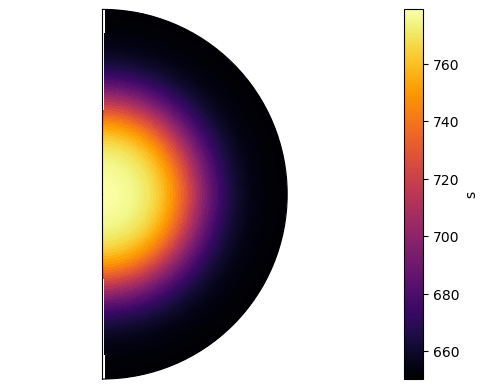

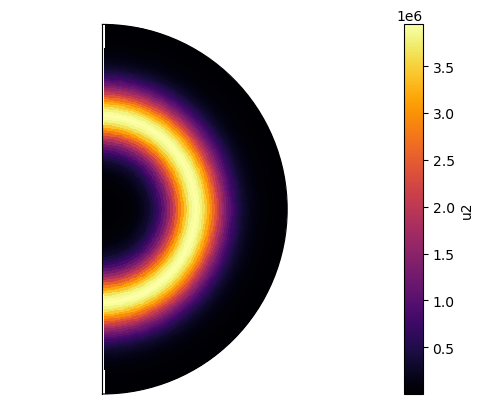

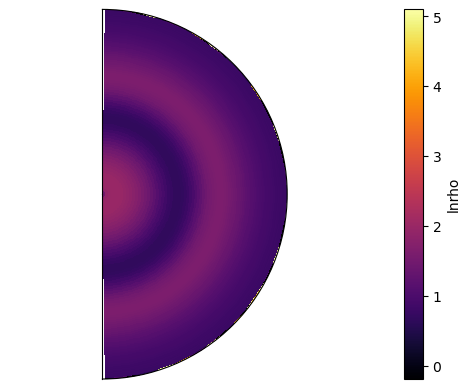

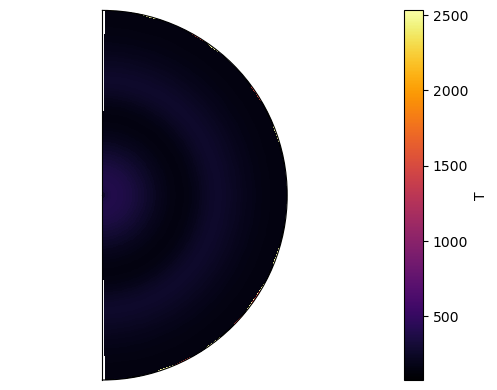

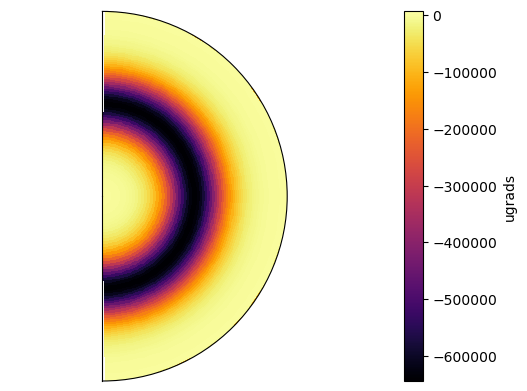

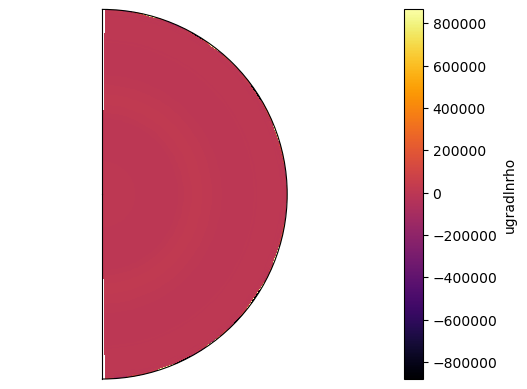

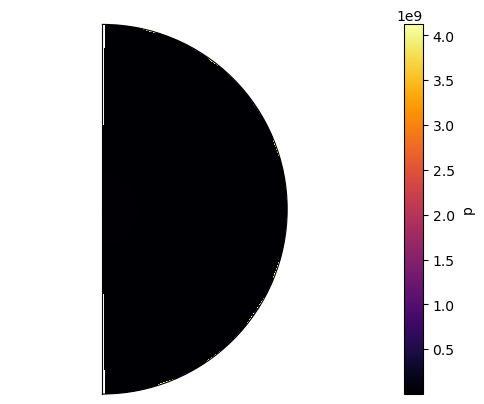

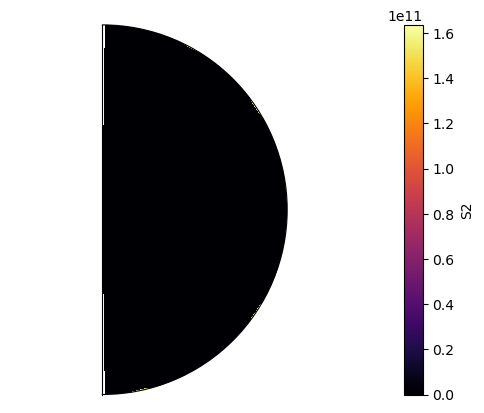

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import h5py
import matplotlib.animation as manimation
import shutil
from scipy.special import erf
from matplotlib.colors import ListedColormap

task_list = ['s','u2','lnrho','T','ugrads','ugradlnrho','p','S2','gradlnrho']



it = 1
for i in range(8):
    taskname = task_list[i]
    with h5py.File("snapshots/snapshots_s1.h5", mode='r') as file:
        fig,(ax) = plt.subplots(1,1,subplot_kw={'projection':'polar'})
        # Load datasets
        lapu = file['tasks'][taskname]
        t = lapu.dims[0]['sim_time']
        phi = lapu.dims[1][0]        
        theta = lapu.dims[2][0]
        r = lapu.dims[3][0]
        Theta, R = np.meshgrid(theta, r)
        ax.set_theta_zero_location('N')       # Cero en el norte (arriba)
        ax.set_theta_direction(-1)  
        ax.set_thetamax(180)
        ax.set_yticks([])
        ax.set_xticks([])
        colormesh = lapu[it][0]
        cmap = "inferno"
        pcm = ax.pcolormesh(Theta,R,np.transpose(colormesh), shading="nearest", cmap=cmap)
        cb = fig.colorbar(pcm, ax=ax, orientation='vertical',label=taskname)
        plt.savefig(f"{taskname}.pdf")


# Debugging:
Remarks:
- The term $u\cdot \nabla s$ reaches values well beyond $10^9$ for the second iteration. This is strange because in this same iteration, the value for $u^2$ is zero
- The term $S^2$ reaches the infinity of the machine in the second iteration.
- The pressure also reaches high values in the first iteration and for the second iteration is already nan